# Introduction to Automatic Hyperparameter Tuning

> Also known as AutoML, Automatic Machine Learning, Meta-optimization, Meta-learning, and so on.

So not only you want to build neural networks and other machine learning algorithms, but also you want to find the best hyperparameters for them automatically. We'll here demonstrate how it's possible with Neuraxle. 

Let's first explore the hyperparameter distributions that are available by plotting them, then let's see how we can narrow hyperparameter spaces and define new statistical hyperparameter distributions. 

## Plotting Each Hyperparameter Distribution

Let's first define a few functions to then plot them each. 

In [1]:
# Note: some of the code in the present code block is derived from another project licensed under The MIT License (MIT), Copyright (c) 2017 Vooban Inc. For the full information, see:
#     https://github.com/guillaume-chevalier/Hyperopt-Keras-CNN-CIFAR-100/blob/Vooban/LICENSE

from neuraxle.hyperparams.distributions import *
from neuraxle.hyperparams.space import HyperparameterSpace
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde

%matplotlib inline

NUM_TRIALS = 10000


def plot_distribution(title: str, distribution: HyperparameterDistribution):
    samples = np.array([
        distribution.rvs() for _ in range(NUM_TRIALS)
    ]).flatten()
    
    x_domain = np.linspace(min(samples), max(samples), NUM_TRIALS)

    plt.figure(figsize=(17,5))
    
    hist = gaussian_kde(samples, 0.001)
    plt.plot(x_domain, hist(x_domain), label="True Histogram")
    
    blurred_hist = gaussian_kde(samples, 0.1)
    plt.plot(x_domain, blurred_hist(x_domain), label="Smoothed Histogram")
    
    plt.title("Histogram (pdf) for a {} distribution".format(title))
    plt.legend()
    plt.show()

def plot_hyperparameter_space(hyperparameter_space: HyperparameterSpace):
    for title, distribution in hyperparameter_space.items():
        plot_distribution(title, distribution)


### Continuous Hyperparameter Distributions

Here are a usage example of the continuous hyperparameter distributions, as well as charts. Those are probably the ones you'll most use. 

Note: the orange lines are blurred averages of the blue lines to see the overall trend. You can ignore the weird border effect at the left and right of the distributions, which in fact just blurs to zero.

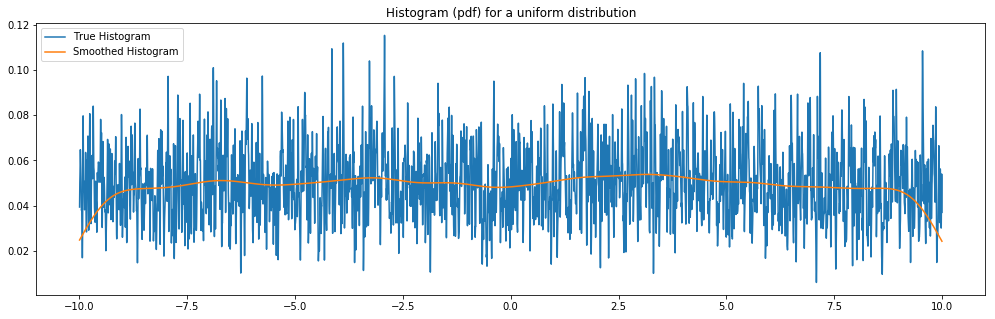

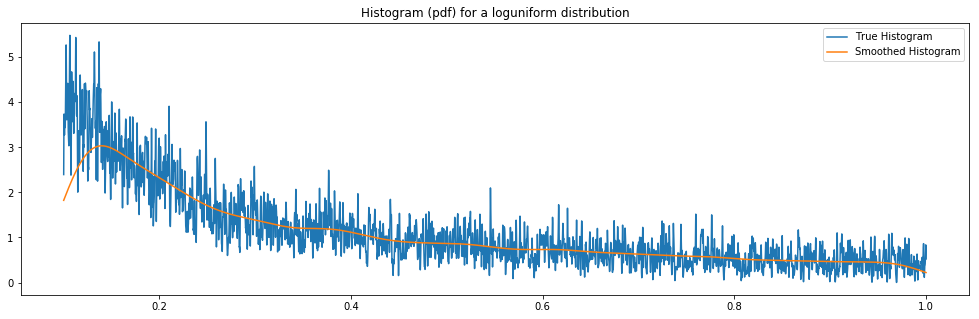

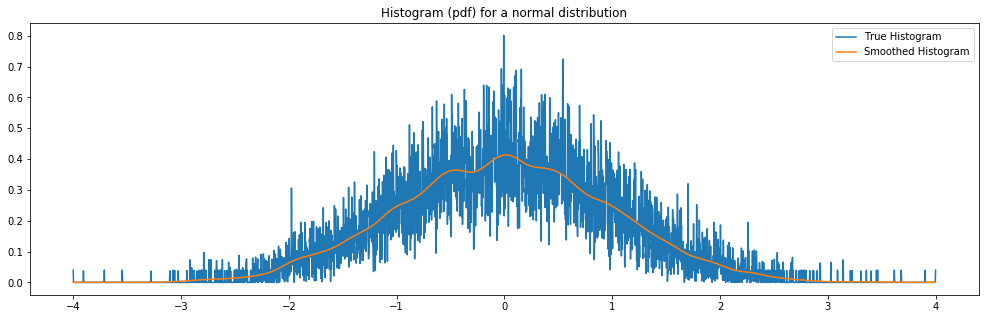

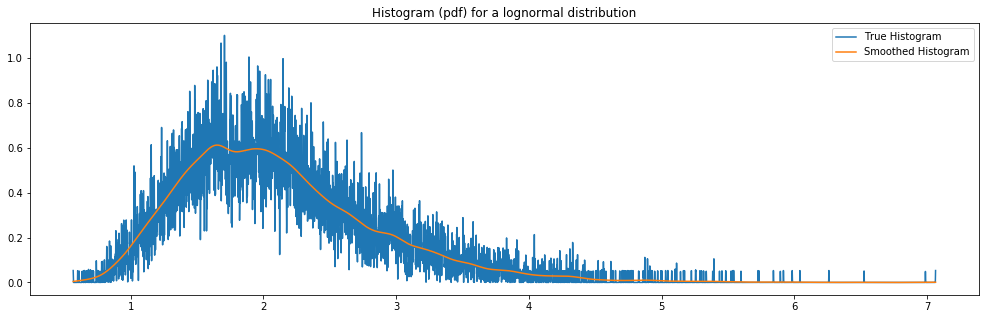

In [2]:
continuous_hyperparameter_space = HyperparameterSpace({
    "uniform": Uniform(-10, 10),
    "loguniform": LogUniform(0.1, 1),
    "normal": Normal(0.0, 1.0, hard_clip_min=-4, hard_clip_max=4),
    "lognormal": LogNormal(1.0, 0.5, hard_clip_min=0, hard_clip_max=10)
})
plot_hyperparameter_space(continuous_hyperparameter_space)

### Quantized Hyperparameter Distributions

Here are now the quantized hyperparameter distributions. Those are distributions that yield integers or other precise specific values. 

Also, notice how there are border effects to the left and right of the charts when we use `Quantized(...)` as a distribution wrapper to round the numbers. Those weird border effect wouldn't appear if you'd limit the distribution to half numbers instead of plain number. Let's say you have a `Quantized(Uniform(-10, 10))`: then the samples from approximately -9.5 to -8.5 are rounded to the bin of the number -9, but the values from -10 to -9.5 are rounder to the bin -10 and a half is missing, so the -10 bin sees its values sampled half as often as -9. That explains the border effect, and you could fix it easily by taking the uniform range from -10.49999 to 10.49999.

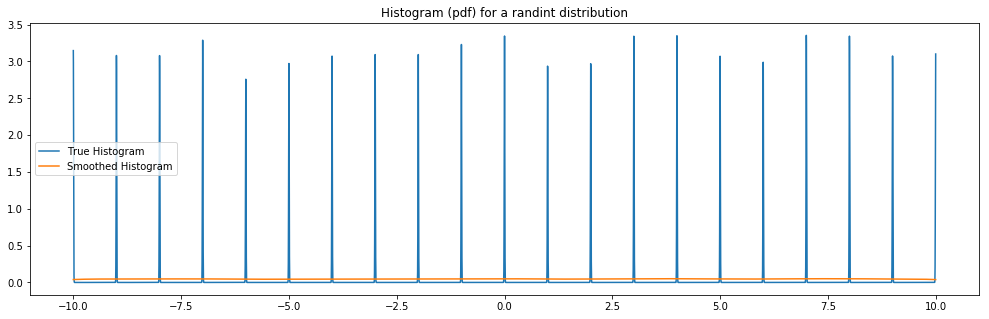

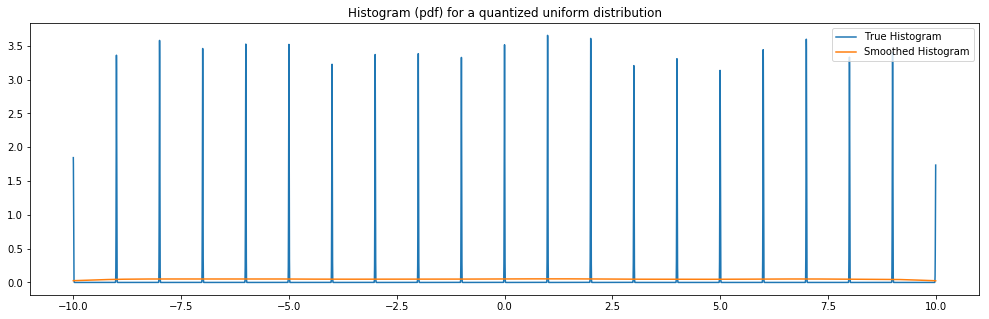

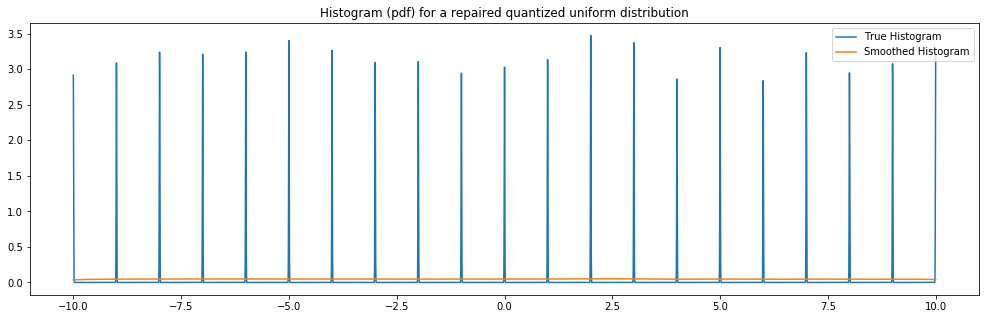

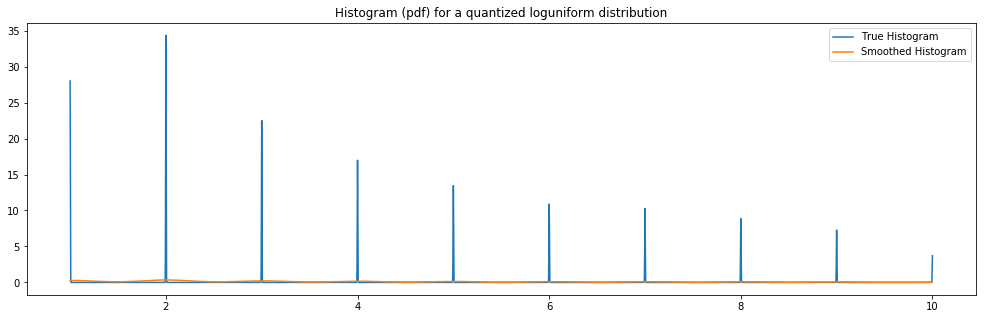

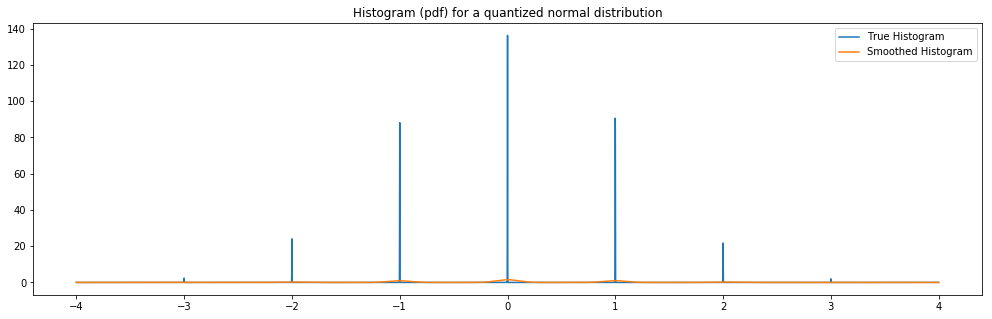

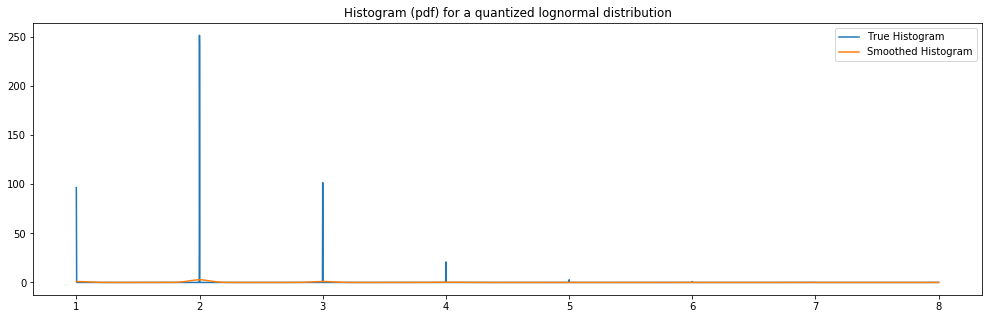

In [3]:
quantized_hyperparameter_space = HyperparameterSpace({
    "randint": RandInt(-10, 10),
    "quantized uniform": Quantized(Uniform(-10, 10)),
    "repaired quantized uniform": Quantized(Uniform(-10.49999, 10.49999)),
    "quantized loguniform": Quantized(LogUniform(1.0, 10.0)),
    "quantized normal": Quantized(Normal(0.0, 1.0, hard_clip_min=-4, hard_clip_max=4)),
    "quantized lognormal": Quantized(LogNormal(1.0, 0.5, hard_clip_min=0.0001, hard_clip_max=10))
})
plot_hyperparameter_space(quantized_hyperparameter_space)

### Other Hyperparameter Distributions

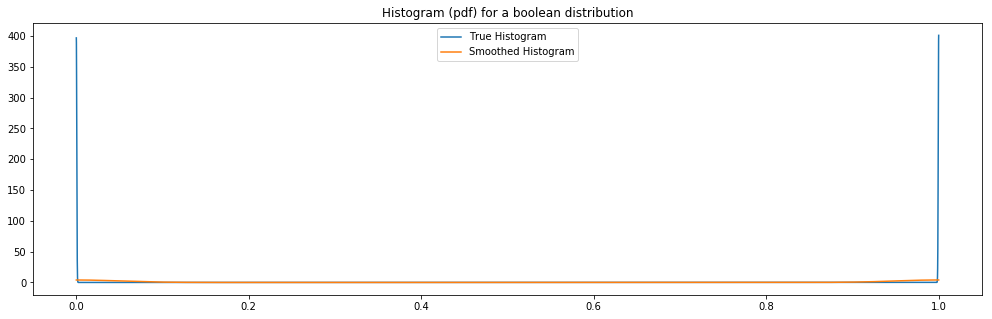

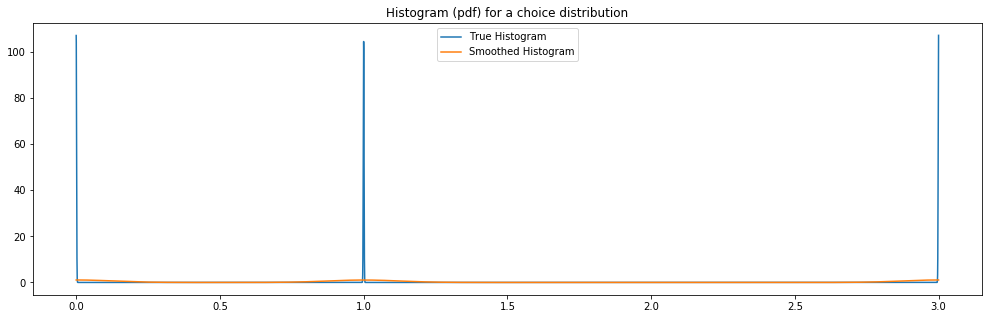

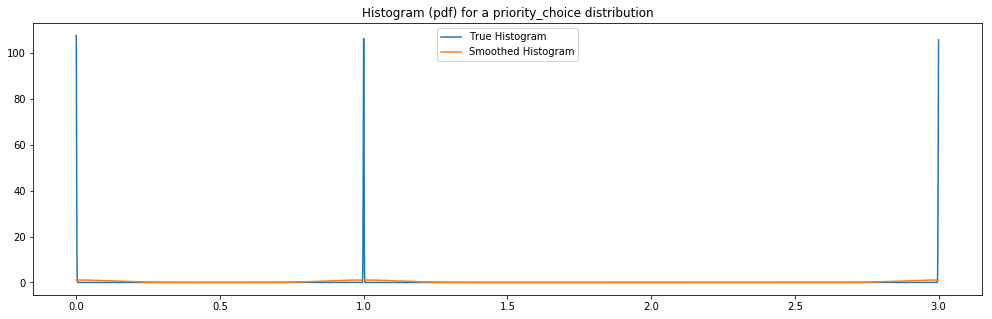

In [4]:
other_hyperparameter_space = HyperparameterSpace({
    "boolean": Boolean(),
    "choice": Choice([0, 1, 3]),
    "priority_choice": PriorityChoice([0, 1, 3])
})
plot_hyperparameter_space(other_hyperparameter_space)

There is finally also the FixedHyperparameter distribution, which you can create to return always the same value. For example, `FixedHyperparameter(42)`. Althought using the number 42 directly would do the job, some of the above hyperparameter distributions may return FixedHyperparameter distributions when narrowed. 


## Narrowing Hyperparameter Spaces: a Detailed Example

You now took a look at the basic hyperparameter distributions available in Neuraxle. For each of them, it's possible to narrow them down to a smaller range as the hyperparameter search progresses and converges towards best guesses. 

It's possible to take a sample from the distribution and to send them to the space and to ask to narrow down the space towards this sample. Each distributions behave differently. 

For example, the Choice will take the best guess instantly when being narrowed but IF the narrowing ratio is small enough for only one item to be kept, proportionally. You could instead use the PriorityChoice which would remove each options by keeping the ones at the beginning of the list, and also bringing back to the beginning the best guess every time. Let's look at a concrete example below. 

Here is the hyperparameter space BEFORE narrowing:


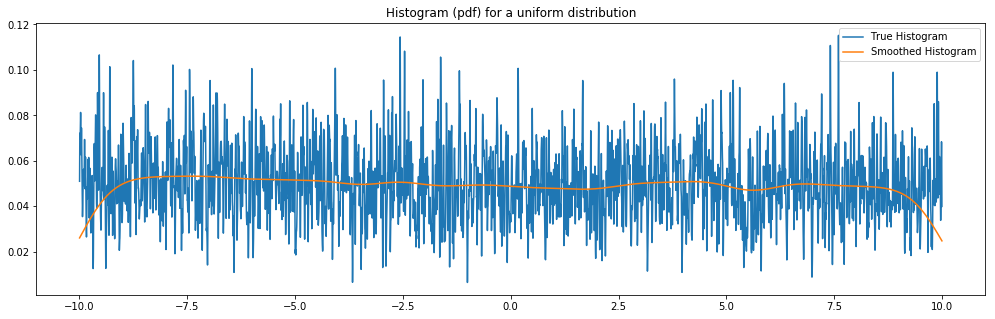

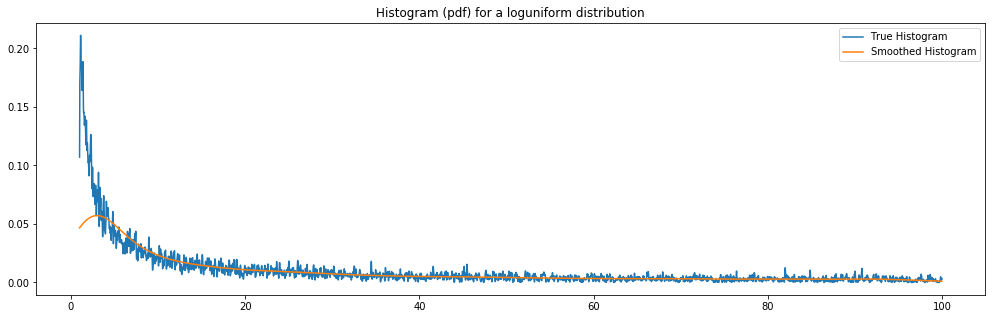

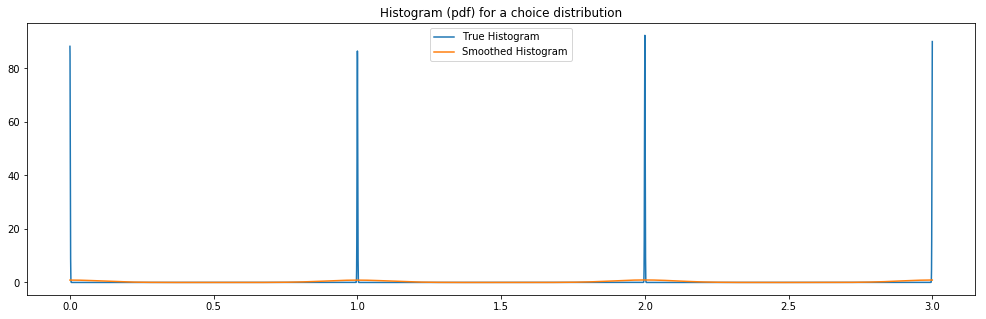

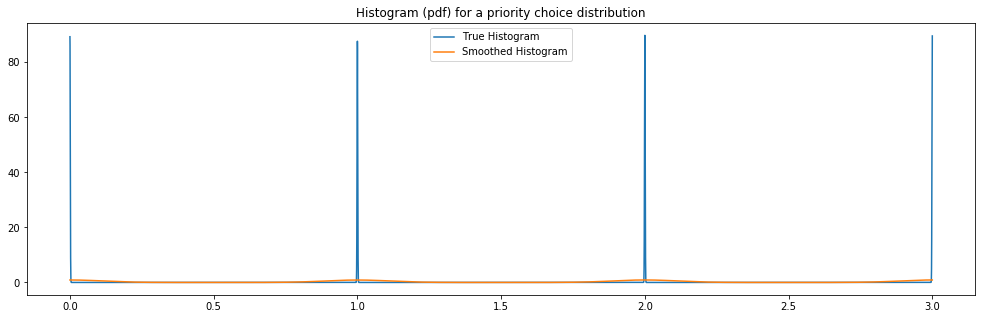

Here is a sample from the hyperparameter space towards which we'll narrow the space:
HyperparameterSpace([('uniform', -1.7456722300162077), ('loguniform', 89.12350621501227), ('choice', 2), ('priority choice', 2)])
Note that we'll narrow the space towards that, and by also using `kept_space_ratio=0.5` which will split the space in half.
Here is the hyperparameter space AFTER narrowing:


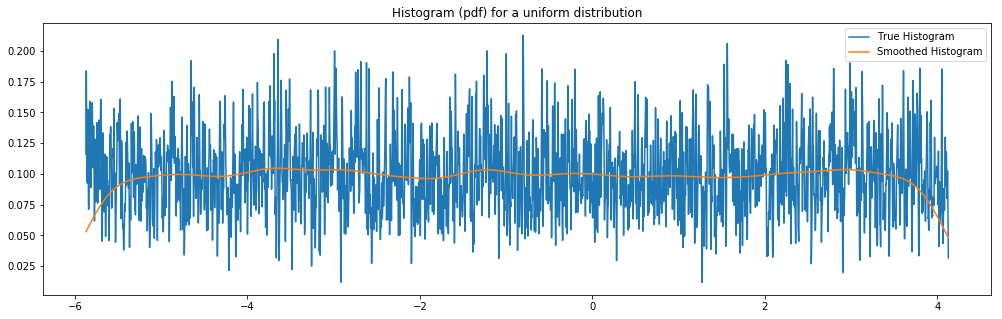

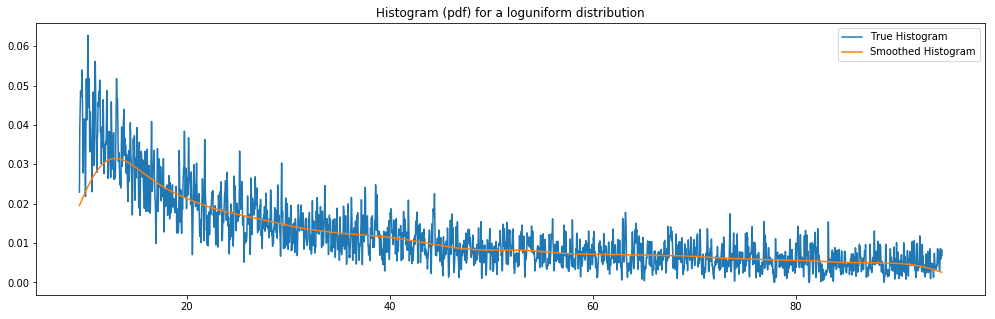

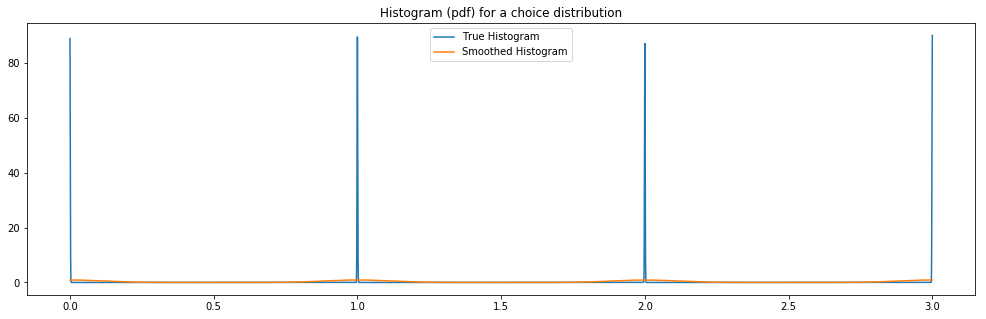

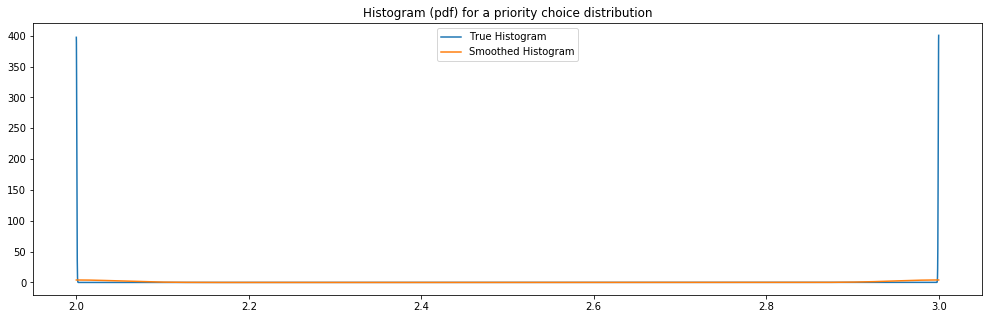

Here is a sample from the NARROWED hyperparameter space:
HyperparameterSpace([('uniform', 3.5066179759945335), ('loguniform', 91.37111758300118), ('choice', 0), ('priority choice', 2)])
Note that you could narrow the space as many times in a row as you want, and also restore it to its default with a call to `.unnarow()` to restore it to non-narrowed settings.


In [5]:

hyperparameter_space_to_narrow = HyperparameterSpace({
    "uniform": Uniform(-10, 10),
    "loguniform": LogUniform(1, 100),
    "choice": Choice([3, 0, 1, 2]),
    "priority choice": PriorityChoice([3, 0, 1, 2]),
})
print("Here is the hyperparameter space BEFORE narrowing:")
plot_hyperparameter_space(hyperparameter_space_to_narrow)

sample = hyperparameter_space_to_narrow.rvs()
print("Here is a sample from the hyperparameter space towards which we'll narrow the space:")
print(sample)
print("Note that we'll narrow the space towards that, and by "
      "also using `kept_space_ratio=0.5` which will split the space in half.")

hyperparameter_space_to_narrow = hyperparameter_space_to_narrow.narrow_space_from_best_guess(
    sample, kept_space_ratio=0.5)

print("Here is the hyperparameter space AFTER narrowing:")
plot_hyperparameter_space(hyperparameter_space_to_narrow)

sample = hyperparameter_space_to_narrow.rvs()
print("Here is a sample from the NARROWED hyperparameter space:")
print(sample)
print("Note that you could narrow the space as many times in a row as you want, and also restore "
      "it to its default with a call to `.unnarow()` to restore it to non-narrowed settings.")

hyperparameter_space_to_narrow = hyperparameter_space_to_narrow.unnarrow()



## Creating your own distributions

Why would we limit our users to use just the pre-made distributions?!

Each distribution inherits and implements a base distribution class named HyperparameterDistribution which you can inherit and implement as needed. The most important is to define the `.rvs()` function that will sample a random value from the distribution, and also to implement the method `narrow_space_from_best_guess(...)` so as to tell the distribution how to be narrowed. Finally, the call to `super(...).__init__()` needs to be done in the `__init__`.

It's easier than it looks! Here is for example how the RandInt distribution is coded: 

In [6]:

class RandInt(HyperparameterDistribution):
    """Get a random integer within a range"""

    def __init__(self, min_included: int, max_included: int):
        """
        Create a quantized random uniform distribution.
        A random integer between the two values inclusively will be returned.

        :param min_included: minimum integer, included.
        :param max_included: maximum integer, included.
        """
        self.min_included = min_included
        self.max_included = max_included
        super(RandInt, self).__init__()

    def rvs(self) -> int:
        """
        Will return an integer in the specified range as specified at creation.

        :return: an integer.
        """
        return random.randint(self.min_included, self.max_included)

    def narrow_space_from_best_guess(self, best_guess, kept_space_ratio: float = 0.5) -> HyperparameterDistribution:
        """
        Will narrow the underlying distribution towards the best guess.

        :param best_guess: the value towards which we want to narrow down the space. Should be between 0.0 and 1.0.
        :param kept_space_ratio: what proportion of the space is kept. Default is to keep half the space (0.5).
        :return: a new HyperparameterDistribution that has been narrowed down.
        """
        lost_space_ratio = 1.0 - kept_space_ratio
        new_min_included = round(self.min_included * kept_space_ratio + best_guess * lost_space_ratio)
        new_max_included = round(self.max_included * kept_space_ratio + best_guess * lost_space_ratio)
        if new_max_included <= new_min_included or kept_space_ratio == 0.0:
            return FixedHyperparameter(best_guess).was_narrowed_from(kept_space_ratio, self)
        return RandInt(new_min_included, new_max_included).was_narrowed_from(kept_space_ratio, self)


If you ever add new distributions, we'd be glad that you open a pull request to add them. 

